# Analyse des données textuelles

À partir des données l'application [Yelp](https://www.yelp.fr), traiter les sujets d'insatisfaction dans les commentaires client.

**Analyser les commentaires pour détecter les différents sujets d’insatisfaction**
 - pré-traitement des données textuelles
 - utilisation de techniques de réduction de dimension
 - visualisation des données de grandes dimensions

**Collecter un échantillon (environ 200 restaurants) de données via l’API Yelp**
 - récupérer uniquement les champs nécessaires
 - stocker les résultats dans un fichier exploitable (par exemple csv)
 
 
Cette deuxième partie concerne le modèle **K-means** afin de trouver le nombre et le genre des sujets d'insatisfaction.



## K-means
**K-means** est un algorithme non supervisé de clustering non hiérarchique. Il permet de regrouper en K clusters distincts les observations du data set. Ainsi les données similaires se retrouveront  dans un même cluster. Par ailleurs, une observation ne peut se retrouver que dans un cluster à la fois (exclusivité d’appartenance). Une même observation, ne pourra donc, appartenir à deux clusters différents.

Nous allons utiliser les mêmes données mais au lieu de créer un corpus, nous allons créer des vecteurs pour chaque commentaires.

Pour estimer le nombre de topics nous allons utiliser l'inertie, qui est définie comme la somme des distances euclidiennes entre chaque point et son centroïde associé. Nous utiliserons aussi le score de silhouette qui est la différence entre la distance moyenne avec les points du même groupe que lui et la distance moyenne avec les points des autres groupes voisins.

# Chargement des bibliothèques

In [1]:
import numpy as np
import pandas as pd

import progressbar

from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans

import pickle

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Markdown, Latex

In [2]:
# Nécessaire lors de la phase de développement pour mettre à jour la classe olist dans le notebook
%load_ext autoreload
%autoreload 2

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
data_dir = '../data/'

# Entrainement du modèle

## Chargement des données précédement traitées

In [5]:
df = pd.read_csv(data_dir + 'train_reviews.csv')
test = pd.read_csv(data_dir + 'test_reviews.csv')

## Création du corpus

In [6]:
tf_idf = TfidfVectorizer()
tf_idf_data = tf_idf.fit_transform(df['clean_text'])
pickle.dump(tf_idf, open("models/TfidfVectorizer.pkl", "wb"))

## Recherche du nombre de topics
Pour la recherche du nombre optimale de topics, nous allons utiliser le coefficient de silhoutte et l'inertie.

Le **coefficient de Silhouette** vérifie si chaque document a bien été classé. Un document est bien classé si la distance qui le sépare de la classe la plus proche est très supérieure à celle qui le sépare de sa classe.


La mesure d'**inertie** est la distance par rapport au point représentant la classe.Par  conséquent,  une  valeur  faible  de  l’inertie intra-classes décrit une homogénéité des données à l’intérieur des classes. Plus la valeur sera faible meilleur sera la segmentation

In [7]:
# Initialisation
inertia = []
scores = []

In [8]:
for num_topics in range(2, 20, 3):    
    kmeans = MiniBatchKMeans(n_clusters=num_topics, init='k-means++', random_state=63, max_iter=300, n_init=100)               
    kmeans .fit(tf_idf_data)
    inertia.append(kmeans.inertia_)
    labels = kmeans.labels_
    score = metrics.silhouette_score(tf_idf_data, labels, metric='cosine')
    scores.append(score)
    print(f"Cluster {num_topics}: Silhouette score {score:.4f}, inertie : {kmeans.inertia_:.4f}")                            

Cluster 2: Silhouette score 0.0050, inertie : 57503.5300
Cluster 5: Silhouette score 0.0043, inertie : 57182.1862
Cluster 8: Silhouette score 0.0025, inertie : 56936.2023
Cluster 11: Silhouette score 0.0074, inertie : 56509.1246
Cluster 14: Silhouette score -0.0289, inertie : 56730.9451
Cluster 17: Silhouette score -0.0321, inertie : 56583.4624


Text(0.5, 1.0, 'Estimation du nombre de clusters avec inertie')

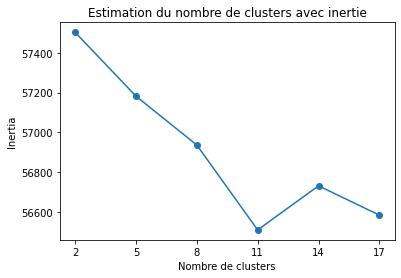

In [9]:
f, ax = plt.subplots(1, 1)
ax.plot(range(2, 20, 3), inertia, marker='o')
ax.set_xlabel('Nombre de clusters')
ax.set_xticks(range(2, 20, 3))
ax.set_xticklabels(range(2, 20, 3))
ax.set_ylabel('Inertia')
ax.set_title('Estimation du nombre de clusters avec inertie')

Text(0.5, 1.0, 'Estimation du nombre de clusters avec le coefficient de silhouette')

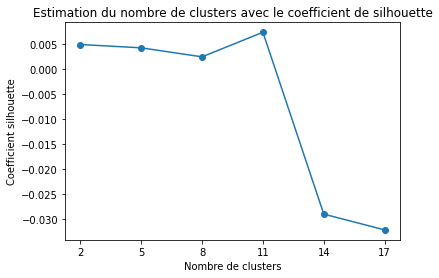

In [10]:
f, ax = plt.subplots(1, 1)
ax.plot(range(2, 20, 3), scores, marker='o')
ax.set_xlabel('Nombre de clusters')
ax.set_xticks(range(2, 20, 3))
ax.set_xticklabels(range(2, 20, 3))
ax.set_ylabel('Coefficient silhouette')
ax.set_title('Estimation du nombre de clusters avec le coefficient de silhouette')

# Sélection du nombre de topics
D'après le coefficient de silhoutte et le l'intertie le nombre de topics optimal est de 11.

In [11]:
num_topics = 11

In [12]:
kmeans = MiniBatchKMeans(n_clusters=num_topics, init='k-means++', random_state=63, max_iter=300, n_init=100)               
kmeans .fit(tf_idf_data)
pickle.dump(kmeans, open("models/kmeans.pkl", "wb"))

# Explication des topics

In [13]:
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
words = tf_idf.get_feature_names()
topics = {}
for cluster in range(num_topics):
    print(f"Cluster {cluster}")
    w = []
    for idx in order_centroids[cluster, :5]:
        w.append(words[idx])
    topics[cluster] = w
    print(f"\t{w}")

Cluster 0
	['coffe', 'cup', 'place', 'breakfast', 'shop']
Cluster 1
	['chicken', 'rice', 'order', 'fri', 'food']
Cluster 2
	['bbq', 'rib', 'brisket', 'pork', 'sauc']
Cluster 3
	['pizza', 'order', 'crust', 'chees', 'place']
Cluster 4
	['taco', 'order', 'food', 'bell', 'mexican']
Cluster 5
	['order', 'wait', 'call', 'time', 'minut']
Cluster 6
	['burger', 'fri', 'order', 'food', 'good']
Cluster 7
	['sandwich', 'order', 'bread', 'chees', 'good']
Cluster 8
	['bar', 'bartend', 'drink', 'beer', 'servic']
Cluster 9
	['food', 'place', 'good', 'servic', 'like']
Cluster 10
	['us', 'tabl', 'food', 'wait', 'minut']


 **Service**

 - food, place, good, servic, like
 - bar, bartend, drink, beer, servic


**Nourriture**

 - bbq, rib, brisket, pork, sauc

**Commande**

 - burger, fri, order, food, good
 - sandwich, order, bread, chees, good
 - chicken, rice, order, fri, food
 - taco, order, food, bell, mexican

**Emplacement**

 - coffe, cup, place, breakfast, shop
 - pizza, order, crust, chees, place


**Attente**

 - us, tabl, food, wait, minut
 - order, wait, call, time, minu


# Prédictions


## Prédiction avec de données de test

In [14]:
new_data_vectorized = tf_idf.transform(test['clean_text'])
test['kmeans_pred'] = pd.Series(kmeans.predict(new_data_vectorized),  index=test.index)

for index, row in test.iterrows():        
    display(Markdown(f"**Topic {row['kmeans_pred']} - {topics[row['kmeans_pred']]}**"))
    display(Markdown(f"> {row['text']}"))    

**Topic 5 - ['food', 'go', 'service', 'get', 'place']**

> Rude staff. Came today, walked in.... No one here ( now I understand why )... The Greeter ( of all people ) provided me this sub-par performance.  Me - as she is seating me outside,,, "so do ya think it's gonna rain."  Greeter - "I don't know, I don't work for the weather department".   I'll never come back to this crappy.

**Topic 10 - ['coffee', 'get', 'tea', 'place', 'good']**

> Bagels on point - no worries there. BUT cleanliness was seriously lacking. All pretty young people working here , while I was waiting for a new batch of coffee to brew, I was watching employees work and a couple of them whotou he's food had gloves on , but the barista/coffee dude literally was scratching his scalp and skin and then making drinks. Just NO. Floors were sticky. Bathroom was a mess. Self serve coffee bar had milk and sugar all over it. Just a hot mess. But like I said if you're here for bagels you're all good. Coffee... NOT their specialty. I could've assumed that. My bad.

**Topic 1 - ['taco', 'fish', 'chip', 'order', 'food']**

> This place is Meh. Looking at the menu, it is very generic. I guess since it is a chain, not very authentic. Also the food is very bland with no flavor. I ordered black beans, they were basically just black beans out of the can that I could have eaten at home. And then they don't even offer complimentary chips and salsa??? Also the waitress got our order wrong, even after she repeated it to us. I just was not impressed. And I am sad, because its walking distance and I was really hoping for this to be my new spot. But oh well. Maybe you will have a better experience. But if I am craving some tex mex or tacos, I will not be coming here.

**Topic 5 - ['food', 'go', 'service', 'get', 'place']**

> In a nutshell...warmed over food.    1, Luke warm, twice cooked crab legs that LOOKED as if they were on their second presentation.  A fresh claw was mixed in for proper deception. 2. Burnt and dried out baked potato....sent back. A fresh one was delivered much later. (NEVER received the requested sour cream).  3. Video music increased a whole decibel by the half hour to the point where conversation with friends was virtually impossible!   I doubted the place when the invitation was offered to join friends there for Girls Night. Unfortunately, my  expectations were confirmed. I left early. I found out later that my friends quickly followed suit.  A waste of money and time for ladies who simply wanted a crab legs - girls night out in OUR community.

**Topic 3 - ['chicken', 'rice', 'taste', 'order', 'sushi']**

> It is trash there was a rat in my soup and it bit me and gave me ebola at least the chicken was good and the rat wasn't even cooked

**Topic 0 - ['egg', 'breakfast', 'bacon', 'toast', 'order']**

> I have been to this location twice now. The first time we experienced poor service, a dirty restaurant, and our food came out piece by piece over a course of 10 minutes. Yesterday I returned for carry out. My sausage biscuit breakfast was made using an uncooked English muffin. We arrived 20 minutes after ordering (they told us it'd be ready in 15) and still waited 10 minutes before receiving our meal.  As an ex-employee of Bob Evans and customer of many locations across the country, this has been the worst one I've seen. I do not recommend eating here.  There are a number of better breakfast options in the area such as Scottys just west on broad st..

**Topic 8 - ['food', 'good', 'place', 'burger', 'price']**

> BOO! We walked in before seeing a movie at the Hollywood theater. Place was empty. Wife got a beer. I ordered water. Look at the menu. I went for the "stuffed" burger. Wife got Fish n chips. Food took a while and the place filled up pretty quickly. My burger was way over cooked and not stuffed. laying one piece of bacon between two thin burger patties and pressing them together is not stuffed. The fish and chips were oily and heavy on the breading. wife pulled the fish out of the center and it was mostly fresh tasting.  Like I said, I orders water and the wife ordered a beer. After we got our food, the waitress never came back for refills.  I was dying. super dry burger, no water, and no waitress. Once we had been done eating for 10 minutes she wondered by with water and we got our check. 10 minutes later I went to the bar to pay my bill. I can't say I will ever find a reason to go back.

**Topic 2 - ['wait', 'minute', 'table', 'come', 'get']**

> Had a great experience before so for a special occasion I wanted to try again. Requested a specific area to sit and was seated there immediately. The server said they were running behind and asked for our patience. No problem as we were not in a hurry. Ordered calamari as appetizer which was great but took 40 minutes to get. 50 minutes later our meal came. It was obvious that the meals had been placed under the warming lights for some time. The lobster tail was dry on the top and so was the steak. This did not make sense that the meal was under the heating lights at all if they were running behind.  Can't honestly say it was the server or the restaurant. We ate and the meals were tasty but not up to our expectations nor even close to our previous experience. Asked the server to speak to the manger about our experience and what seemed to be excessive fat in the prime rib........we left because the manager did not come to the table and  over 2 hours of this dining experience was enough. I will try them again only because my first experience was so great.

**Topic 5 - ['food', 'go', 'service', 'get', 'place']**

> We are from our of town so our first time in. Bartender was not friendly, didn't explain or care to inform us of some of the local beers on tap. Nice place to bad we had horrible experience here. Go to other places in area besides this place when visiting Vancouver, Washington.

**Topic 8 - ['food', 'good', 'place', 'burger', 'price']**

> Used to really like this place but the food seems more and more bland. Maybe because the menu has not changed since the 20th century. One plus of this place was that it was a BYOB. No more. Now if you want to have a beer with dinner you have a choice of Bud and Bud Light. BORING. At least the beer is consistent with the menu. One less reason to go to Mario's.

## Prédiction avec de nouvelles données en provenance de l'API Yelp

## Chargement des données

In [15]:
new_df = pd.read_csv(data_dir + 'london_sample.csv')

## Prédictions

In [16]:
new_data_vectorized = tf_idf.transform(new_df['clean_text'])
new_df['kmeans_pred'] = pd.Series(kmeans.predict(new_data_vectorized),  index=new_df.index)

In [17]:
for index, row in new_df.iterrows():        
    display(Markdown(f"**Topic {row['kmeans_pred']} - {topics[row['kmeans_pred']]}**"))
    display(Markdown(f"> {row['text']}"))    

**Topic 6 - ['order', 'get', 'time', 'food', 'take']**

> Terrible service from the time I sat down. Had to flag down multiple people other than our actual waitress whom was nowhere to be found in order to order...

**Topic 7 - ['pizza', 'order', 'crust', 'cheese', 'get']**

> If you like Burned Pizza and Bad Service that is the place for you. We ordered a pizza to go and the pizza was soggy, soft and very burned under the...

**Topic 5 - ['food', 'go', 'service', 'get', 'place']**

> We were frequent visitors of Vapiano's when we lived in Vienna, so we know what to expect, and I have to say their food and service were always...

**Topic 2 - ['wait', 'minute', 'table', 'come', 'get']**

> Walked in for dinner. First night in London and super excited for meat & ale pie. Sat at a table upstairs. 10 minutes went by and no one came around at all....

# Conclusion
Avec un algorithme de K-means le nombre de catégories est le même que le modèle LDA. Les mots qui compose chaque catégories est légèrement différent, mais le sens reste le même. 